# Solving Cartpole v0 using NFQ with Experience Replay

In the following is an implementation described Chapter 8 of [Grokking Deep Reinforcement Learning](https://www.manning.com/books/grokking-deep-reinforcement-learning). NFQ was originally introduced in 2005 by Martin Reidmiller in a paper called __"Neural Fitted Q Iteration - First Experiences with a Data Efficient Neural Reinforcement Method"__. I have made a few optimizations to it. 

The environment Cartpole-v0 is used to test the algorithm, was created by OpenAi and is described in more detail here [cartpolev0](https://github.com/openai/gym/wiki/CartPole-v0) and here [doc](https://gym.openai.com/docs/).

If the algorithm manages to execute the simulation of the cartpole for a 100 episodes, keeping it balanced for more then 195 steps the environment is said to be solved. 


#TODO: Describe experience replay description

In [9]:
# imports
import random

from itertools import cycle, count
from collections import deque
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym

## The agent

The agent consists for several different elements. There is the FCQ - Fully Connected Q-function. Which contains the neural network. Below the network are two strategies:
* Epsilon greedy strategy
* Greedy strategy

The difference between the two is that the first one selects a random action with epsilon possibility and the greedy choice the rest. The Greedy strategy is always greedy. 

Things to tune could be:
* Demensions of the network
* Activation function

In [10]:
class FCQ(nn.Module):
    """
    Fully Connected Q-function. 
    
    Approximating state-action value function
    """
    
    def __init__(self,
                input_dim,
                output_dim,
                hidden_dim=(512, 128),
                activation_fun=F.relu):
        super(FCQ, self).__init__()
        self.activation_fun = activation_fun
        
        self.input_layer = nn.Linear(input_dim, hidden_dim[0])
        
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dim) - 1):
            hidden_layer = nn.Linear(hidden_dim[i], hidden_dim[i+1])
            self.hidden_layers.append(hidden_layer)
            
        self.output_layer = nn.Linear(hidden_dim[-1], output_dim)
        
        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
    
    def forward(self, state):
        
        x = state
        
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device,
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation_fun(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fun(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def load_into_torch(self, experiences):
        
        experiences = np.array(experiences)
        batches = [np.vstack(sars) for sars in experiences.T]

        states, actions, rewards, next_states, dones = batches
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        dones = torch.from_numpy(dones).float().to(self.device)
        
        return states, actions, rewards, next_states, dones
        

### The two strategies

The `EGreedyStrategy` will offer a random action with espilon probability. The current implementation uses a decaying epsilon, meaning that it starts out with a very high epsilon (0.8) to enable the agent to explore a lot. then every step it will decay until it arrives to `min_epsilon` (0.1)

Things to optimize:
* epsilon
* epsilon_decay
* min_epsilon

In [11]:
class EGreedyStrategy():
    def __init__(self,
                epsilon=0.8,
                epsilon_decay=0.99,
                min_epsilon=0.1):

        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        
    def get_epsilon(self):
        
        self.epsilon *= self.epsilon_decay 
        return min(self.epsilon, self.min_epsilon)
        
    def action(self, model, state):
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
        
        if np.random.rand() > self.get_epsilon():
            action = np.argmax(q_values)
        else:
            action = np.random.randint(len(q_values))
        return action
    
class GreedyStrategy():
    
    def action(self, model, state):
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
            
        return np.argmax(q_values)
        

## The Neural Fitted Q Iteration

The following trains the agent in the environment. 

The agent is training with the Epsilon greedy strategy but is evaluated with the Greedy strategy (in the `evaluate_model` method). 

This is called _off-policy learning_, because it trains a policy different than the one used to create behavior. 

The big question here for me is that it is the Epsilon greedy strategy which wins?



In [16]:
class NFQ():
    """ 
        Agent class 
    """
    
    def __init__(self,
                 model,
                 optimizer, # = optim.RMSprop(model, lr=0.0005),
                 policy = EGreedyStrategy(),
                 evaluation_policy = GreedyStrategy(),
                 batch_size = 1024,
                 epochs = 40,
                 gamma = 0.99
                ):
        self.model = model
        self.optimizer = optimizer
        self.policy = policy
        self.ev_policy = evaluation_policy
        self.batch_size = batch_size
        self.epochs = epochs
        self.gamma = gamma
        self.experiences = []
        from collections import deque
        
    def train(self, 
              env, 
              episodes):
        
        self.experiences = deque(maxlen=10000)
        rewards = []
        train_window = deque(maxlen=100)
        scores_window = deque(maxlen=100)
        
        for i_episode in range(episodes):
            state = env.reset()
            rewards.append(0.0)
            done = False
            while not done:
                # interaction
                action = self.policy.action(self.model, state)
                new_state, reward, done, _ = env.step(action)
                
                rewards[-1] += reward
                
                experience = (state, action, reward, new_state, done)
                
                self.experiences.append(experience)
                
                state = new_state                
                
            train_window.append(rewards[-1])
            
            # train model
            if len(self.experiences) >= self.batch_size:
                experiences = random.sample(self.experiences, self.batch_size)
                experiences = self.model.load_into_torch(experiences)
                for _ in range(self.epochs):
                    self.optimize_model(experiences)
                

            mean_reward, std = self.evaluate_model(env)
            scores_window.append(mean_reward)
            
            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}, train score {:.2f}'.format(i_episode, np.mean(scores_window), np.mean(train_window)))
            if np.mean(train_window) >= 195:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - 100,
                                                                                     np.mean(train_window)))
                torch.save(agent.model.state_dict(), 'checkpoint.pth')
                break
        return rewards
    def evaluate_model(self, env, n_episodes=1):
        rewards = []

        for _ in range(n_episodes):

            state = env.reset()
            rewards.append(0)
            done = False
            while not done:
                action = self.ev_policy.action(self.model, state) 
                next_state, reward, done, _ = env.step(action)
                
                rewards[-1] += reward
                state = next_state
                   
        return np.mean(rewards), np.std(rewards)
        
        
    def optimize_model(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        
        max_q_next_state = (self.model(next_states) # Predict next state action values
                .detach()                           # detach to ensure they wont be used to train model
                .max(1)[0].unsqueeze(1))            # max, and unsqueeze
        
        target_qs = rewards + self.gamma * max_q_next_state * (1 - dones)
        q_sa = self.model(states).gather(1, actions) # what would the model predict
        td_errors = q_sa - target_qs
        
        value_loss = td_errors.pow(2).mul(0.5).mean() # MSE
        self.optimizer.zero_grad()
        value_loss.backward()
        self.optimizer.step()
                
        

In [17]:
# env
env = gym.make('CartPole-v0')

initial_state = env.reset()

action = env.action_space.sample()
state, reward, done, info = env.step(action)

In [18]:
print("state size ", initial_state.shape[0])
print("number of actions ", env.action_space.n)


state size  4
number of actions  2


In [19]:
# train
model = FCQ(initial_state.shape[0],
            env.action_space.n,
           hidden_dim=(512, 256))
agent = NFQ(model, 
            optim.RMSprop(model.parameters(), lr=0.0005))
rewards = agent.train(env, 2000)

Episode 0	Average Score: 8.00, train score 9.00
Episode 100	Average Score: 9.28, train score 9.47


/Users/kifal2/Dropbox/git/reinforcementlearning/venv/lib/python3.7/site-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Episode 200	Average Score: 107.46, train score 107.13
Episode 300	Average Score: 186.82, train score 183.22
Episode 400	Average Score: 157.54, train score 157.43
Episode 500	Average Score: 175.81, train score 176.31
Episode 600	Average Score: 155.57, train score 153.84
Episode 700	Average Score: 133.82, train score 133.61
Episode 800	Average Score: 180.31, train score 180.51

Environment solved in 749 episodes!	Average Score: 195.01


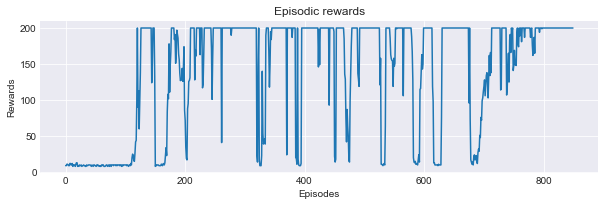

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_rewards(rewards):
    """
    Plot rewards.
    """
    plt.style.use('seaborn-darkgrid')
    fig = plt.figure(figsize=(10,7))
    ax1 = fig.add_subplot(2, 1, 1)
    
    plt.subplots_adjust(hspace=.5)
    
    ax1.set_title('Episodic rewards')
    ax1.plot(rewards, label='Episodic rewards')
    ax1.set_xlabel("Episodes")
    ax1.set_ylabel("Rewards")
    
    plt.show(fig)
    
plot_rewards(rewards)

### Next steps:

* Add experience replay
* Add simulation rendering. 